In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [7]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import image.loadImage as loadImage
import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing
import image.modelsCNN as modelsCNN

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors
from sklearn.preprocessing import MinMaxScaler
import anndata as ad
from sklearn.metrics import pairwise_distances

In [3]:
imageSizes={}
imageSizes['disease13']=(22210, 22344)
imageSizes['control13']=(22355, 18953)
imageSizes['disease8']=(22294, 19552)
imageSizes['control8']=(22452, 19616)

plaqueMaskName='PlaqueMask6'
plaqueMaskImg='Maskofplaque6.tif'
lossThreshSize=1111
hiddendim=6000
useSavedMaskedEdges=True
use_cuda=True

In [5]:
datadir='/home/xinyiz/2021-01-13-mAD-test-dataset'

gaeClusterPath='/mnt/external_ssd/xinyi/plots/train_gae_starmap/allk20XA_02_dca_over/combinedlogminmax_beforeAct/cluster/leiden_nn10mdist025n_pcs40res0.1epoch9990'
with open(gaeClusterPath, 'rb') as input:
    gaeclusterlabels = pickle.load(input)

plot_samples={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}

gaeCoord=None
sampleNames=None
scaleddata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-raw.h5ad')
for s in plot_samples.keys():
    sampleidx_s=plot_samples[s] 
    if gaeCoord is None:
        gaeCoord=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()
        sampleNames=np.repeat(s,np.sum(scaleddata.obs['sample']==sampleidx_s))
    else:
        gaeCoord=np.concatenate((gaeCoord,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()),axis=0)
        sampleNames=np.concatenate((sampleNames,np.repeat(s,np.sum(scaleddata.obs['sample']==sampleidx_s))),axis=None)
gaeCoord=(gaeCoord/0.3).astype(int)
feature_names=scaleddata.var.index
feature_names=feature_names.astype(str)


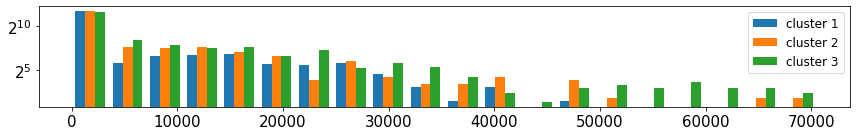

In [40]:
c0='0'
c1='1'
c3='3'
a0=215897
a1= 236653
a3= 166213
areasum=a0+a1+a3
a0=(areasum)/a0
a1=(areasum)/a1
a3=(areasum)/a3
s8='disease8'
# s13='disease13'
idx08=gaeclusterlabels[sampleNames==s8]==c0
idx18=gaeclusterlabels[sampleNames==s8]==c1
idx38=gaeclusterlabels[sampleNames==s8]==c3
# idx013=gaeclusterlabels[sampleNames==s13]==c0
# idx113=gaeclusterlabels[sampleNames==s13]==c1
res=[list(np.array(labellist[s8][idx08])+1),list(np.array(labellist[s8][idx38])+1),list(np.array(labellist[s8][idx18])+1)]
plt.rcParams["figure.figsize"] = (12,2)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
# numbers=plt.hist(res,20)
plt.yscale('log',base=2)
numbers8=plt.hist(res,bins=20,weights=[list(np.repeat(a0,np.array(labellist[s8][idx08]).size)),list(np.repeat(a3,np.array(labellist[s8][idx38]).size)),list(np.repeat(a1,np.array(labellist[s8][idx18]).size))])
plt.legend(['cluster 1','cluster 2','cluster 3'],fontsize=12)
# plt.xlabel('plaque size')
# plt.ylabel('log2 number of plaque')
plt.tight_layout()
plt.savefig('/mnt/external_ssd/xinyi/plots/data/plaqueDistr_logy_d8_wc3_areaNorm.tif',dpi=300)

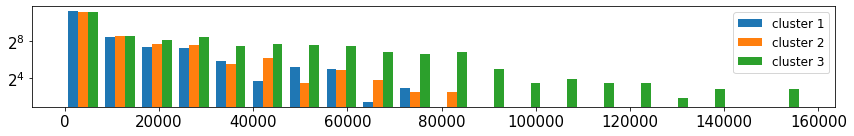

In [88]:
#corrected area; previous version used d8 area
c0='0'
c1='1'
c3='3'
a0=209790
a1= 149957
a3= 190885
areasum=a0+a1+a3
a0=(areasum)/a0
a1=(areasum)/a1
a3=(areasum)/a3
# s8='disease8'
s13='disease13'
# idx08=gaeclusterlabels[sampleNames==s8]==c0
# idx18=gaeclusterlabels[sampleNames==s8]==c1
idx013=gaeclusterlabels[sampleNames==s13]==c0
idx113=gaeclusterlabels[sampleNames==s13]==c1
idx313=gaeclusterlabels[sampleNames==s13]==c3
res=[list(np.array(labellist[s13][idx013])+1),list(np.array(labellist[s13][idx313])+1),list(np.array(labellist[s13][idx113])+1)]
plt.rcParams["figure.figsize"] = (12,2)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
# numbers=plt.hist(res,20)
# plt.xscale('log',base=2)
plt.yscale('log',base=2)
numbers13=plt.hist(res,bins=20,weights=[list(np.repeat(a0,np.array(labellist[s13][idx013]).size)),list(np.repeat(a3,np.array(labellist[s13][idx313]).size)),list(np.repeat(a1,np.array(labellist[s13][idx113]).size))])
plt.legend(['cluster 1','cluster 2','cluster 3'],fontsize=12)
# plt.xlabel('plaque size')
# plt.ylabel('log2 number of plaque')
plt.tight_layout()
plt.savefig('/mnt/external_ssd/xinyi/plots/data/plaqueDistr_logy_d13_wc3_areaNorm.tif',dpi=300)

In [36]:
import scipy.stats

In [49]:
scipy.stats.ttest_rel(numbers8[0][0][1:].flatten(),numbers8[0][2][1:].flatten(),alternative='less')

Ttest_relResult(statistic=-2.727205561138928, pvalue=0.006914048671314312)

In [89]:
scipy.stats.ttest_ind(labellist[s13][idx013],labellist[s13][idx113])

Ttest_indResult(statistic=-18.0333092774563, pvalue=1.7419026860981267e-68)

In [90]:
scipy.stats.ttest_ind(labellist[s13][idx013],labellist[s13][idx313])

Ttest_indResult(statistic=-2.7395043090669047, pvalue=0.006197622633723589)

In [50]:
scipy.stats.ttest_ind(labellist[s8][idx08],labellist[s8][idx18])

Ttest_indResult(statistic=-9.2751594104501, pvalue=3.283175554723873e-20)

In [56]:
scipy.stats.ttest_ind(labellist[s8][idx08],labellist[s8][idx38])

Ttest_indResult(statistic=-3.5301949560973465, pvalue=0.0004228077346633263)